# IU Data Exploration

All images are '.png' images. 

There are 7,470 image files and at first glance, it appears as though there are two images per person, which provides an anterior and lateral view of the person's chest.

There are 3,955 '.xml' files that provide the indication, finding and medical impression of the person in the image. The 'parentImage' tag identifies the corresponding '.png' file.

In [1]:
import os
import pickle
from xml.dom import minidom
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import string
from sklearn.neighbors import KernelDensity
from wordcloud import WordCloud, STOPWORDS
import numpy as np

# Distribution of Words in the Findings

There are 3,425 findings, so some images do not have a corresponding finding.

Examples of findings:
"Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses."

"The heart size and pulmonary vascularity appear within normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. VP shunt tubing is identified. The bony structures, as visualized, appear unremarkable."

___

Prior to observing the distribution of words, the punctuation is removed from the string to prevent counting the punctuation as a word. A word is defined as a string of characters, split by a space.

"Heart size normal Lungs are clear XXXX are normal No pneumonia effusions edema pneumothorax adenopathy nodules or masses"

"The heart size and pulmonary vascularity appear within normal limits Lungs are free of focal airspace disease No pleural effusion or pneumothorax is seen VP shunt tubing is identified The bony structures as visualized appear unremarkable"

In [2]:
findings_lst=[]
for filename in os.listdir('input/ecgen-radiology/'):
    docs = minidom.parse('input/ecgen-radiology/'+filename)
    img_ref = docs.getElementsByTagName("AbstractText")
    
    for i in img_ref:
        if i.getAttribute("Label") == 'FINDINGS': 
            if i.firstChild:
                f=str(i.firstChild.data)
                findings_lst.append(f)
            
len(findings_lst)

3425

Histogram Desity Estimation shows that the distribution is right skewed, further supported by the median being 29 words and the average being 55 words

The histogram is a great first pass to build intuition, but there are two areas that this method does not address:
- Not Smooth
- Shape depends on the bin position 

so we try to estimate the distribution using Kernel Density Estimation (KDE). This results in a smoothed histogram with a Gaussian kernel and bandwidth of 0.8. All 3,425 datapoints were used in a KDE

Median length:  29


<AxesSubplot:xlabel='Number of Words Per Finding', ylabel='Count'>

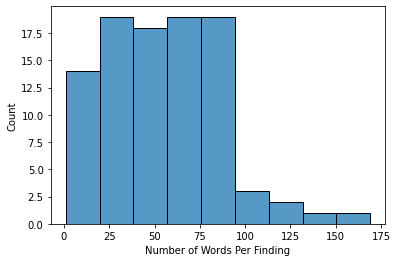

In [3]:
clean_find_lst=[f.translate(str.maketrans('', '', string.punctuation)) for f in findings_lst]
wrds_f_lst=[f.split() for f in clean_find_lst]
len_findings_lst=[len(f) for f in wrds_f_lst]
print("Median length: ",statistics.median(len_findings_lst))
frequency=collections.Counter(len_findings_lst)
dict_label_freq=dict(frequency)
df_label_freq=pd.DataFrame(dict_label_freq.items(), columns=['Number of Words Per Finding', 'Frequency'])

sns.histplot(data=df_label_freq, x="Number of Words Per Finding")

In [4]:
total=0
for l, f in dict_label_freq.items():
    total+=f
probs_len_lst_ref=[(l,round(f/total,2)) for l, f in dict_label_freq.items()] #Calc the relative freq
prob_lst=[p for f,p in probs_len_lst_ref]

(-0.01, 0.6)

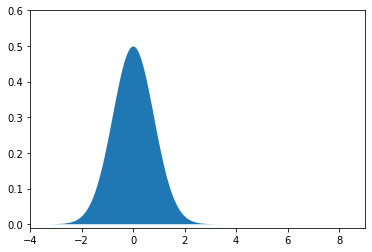

In [5]:
X=[[p]for p in prob_lst]
kde=KernelDensity(kernel='gaussian', bandwidth=0.80).fit(X)
x_ticks = np.linspace(-5, 10, 3425)[:, np.newaxis] # choose 3000 points on x-axis
log_density = kde.score_samples(x_ticks) # compute density at 3000 points
plt.fill(x_ticks[:, 0], np.exp(log_density)) # plot the density estimate
plt.xlim(-4, 9)
plt.ylim(-0.01, 0.6)

In [6]:
len_f_1=[f for f in wrds_f_lst if len(f)==1]
len_f_169=[' '.join(f) for f in wrds_f_lst if len(f)==169]
len_f_29=[' '.join(f) for f in wrds_f_lst if len(f)==29]

In [7]:
df_label_freq_sorted=df_label_freq.sort_values(by=['Number of Words Per Finding'])
df_label_freq.describe()

,Number of Words Per Finding,Frequency
count,96.000000,96.000000
mean,55.416667,35.677083
std,32.473363,42.264205
min,1.000000,1.000000
25%,29.750000,2.000000
50%,53.500000,16.500000
75%,77.250000,58.250000
max,169.000000,178.000000


The minimum number of words is 1 and the maximum number of words is 169. The median number of words is 29 words.

Finding Num Words is 1: "Please"

___

Findings Num Words is 29:

"No pneumothorax or large pleural effusion Mildly prominent perihilar opacities XXXX due to bronchovascular crowding Heart size within normal limits Cardiomediastinal silhouette is XXXX The bony structures appear intact"

"Frontal and lateral views of the chest demonstrate the cardiomediastinal silhouette normal There is normal distribution of the pulmonary vascularity The lungs are clear No effusion consolidation or pneumothorax"


___

Finding Num Words is 169: "Chest Comparison There is a 26 cm diameter masslike density over the lingula partial obscuration left cardiac XXXX There may be some illdefined opacity in the right mid and lower lung zone No pleural effusion is seen The heart is borderline enlarged The aorta is dilated and tortuous Arthritic changes of the spine are present Pelvis and left hip There is an impacted and rotated fracture through the neck of the femur on the left No pelvic fracture is seen Arthritic changes are present in the lower lumbar spine Large amount of stool and XXXX obscures portions of the pelvis Femur The femoral images do not XXXX the area of the hip fracture The remaining portions of the femur appear to be intact with no fracture or destructive process Extensive atherosclerotic vascular disease throughout the superficial femoral artery is present Left knee There is osteoporosis and mild arthritic changes No fracture is seen No dislocation is identified Severe atherosclerotic changes of the superficial femoral and popliteal artery are seen"

___

Recognizing that a note like, "Please" is not incredibly meaningful, we explore removal of outliers to preserve the data quality for later analysis.

# Outlier Detection and Removal

Use the 1.5 inter-quartile rule to remove outliers. 

The lowerbound is calculated to be -2. A medical finding cannot have -2 words, so the lowerboud is set to the minimum number of words in a finding, which is 1.

Removal of the outliers, results in 3,299 captions.

Reference:

https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414

In [8]:
def outlier_treatment(data):
    sorted(data)
    Q1,Q3 = np.percentile(data , [25,75])
    IQR = Q3-Q1
    lower_range = Q1-(1.5*IQR)
    upper_range = Q3+(1.5*IQR)
    
    return lower_range,upper_range

lowerbound,upperbound = outlier_treatment(len_findings_lst)
lowerbound=1
print("Lowerbound: {} \n Upperbound: {}".format(int(lowerbound),int(upperbound)))

findings_without_outliers=[f for f in wrds_f_lst if len(f)>1 and len(f)<63]
print(len(findings_without_outliers))

Lowerbound: 1 
 Upperbound: 62
3299


# Word Cloud of Findings

The most prevalent words in the medical findings are: "pleural effusion," "heart size, and "pneumothorax." These three words are related to medical findings about organs in the chest and validate that the context in these findings are releavnt and meaningful for further downstream analysis.

The words like "XXXX XXXX" and "XXXX" are fairly minimal in the word cloud, so the content is fairly robust and generally medical related. The missing data may be meaningful, but it is not frequent in the findings.

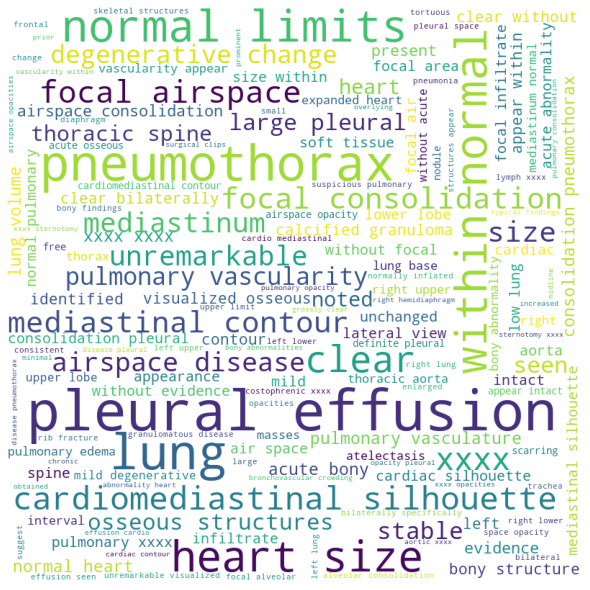

In [29]:
findings_without_outliers_lower_lst=[]
for f in findings_without_outliers:
    for w in f:
        findings_without_outliers_lower_lst.append(w.lower())

findings_without_outliers_lower_str=" ".join(findings_without_outliers_lower_lst)

stopwords = set(STOPWORDS)
wordcloud=WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(findings_without_outliers_lower_str)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Image Size (min, max, average)

All the images have 3 channels and the width of all the images is 512 pixels.

Minimum Image size: (362,512,3)

Maximum Image size: (873,512,3)

Average Image size: (533,512,3)

In [9]:
import glob 
import cv2
# Importing and Loading the data into a data frame

img_shape=[]
for file in glob.glob('input/NLMCXR_png/*.png'):
    file_split_1=file.split(".")
    file_split_2=file_split_1[0].split("/")
    img_indx=file_split_2[2]
    
    img=cv2.imread(file)
    img_shape.append((img_indx,img.shape))

In [10]:
h_arr=[]
w_arr=[]
c_arr=[]

for idx,shape in img_shape:
    h_arr.append(shape[0])
    w_arr.append(shape[1])
    c_arr.append(shape[2])
    
print(list(set(w_arr)),"\n",list(set(c_arr)))

[512] 
 [3]


In [11]:
min(h_arr)

362

In [12]:
max(h_arr)

873

In [13]:
sum(h_arr)/len(h_arr)

532.7789825970549